In [1]:
print("hi")

hi


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14

plt.rcParams['mathtext.rm'] = 'DeJavu Serif'
plt.rcParams['mathtext.it'] = 'DeJavu Serif:italic'
plt.rcParams['mathtext.bf'] = 'DeJavu Serif:bold'

Mbh_std = 1.675002
Mbh_mean = 0.483238518

simpathroot = '/ocean/projects/phy240022p/bwangc/MassGraphNet/SimData'
mass_sim = np.loadtxt('/ocean/projects/phy240022p/bwangc/MassGraphNet/data/sobol_sequence_WDM_real_values.txt')


Mbhs = []

bins = [-1,0,3,3.25,3.5,3.75, 4, 4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25]

data = []

for i in range(0,1024):
    # print('reading simulation', i, flush = True)
    fin = '%s/WDM_%d/fof_subhalo_tab_090.hdf5'%(simpathroot,i)

    f = h5py.File(fin, 'r')

    header = f['Header']
    boxsize = header.attrs[u'BoxSize']

    Mbh  = f['/Subhalo/SubhaloBHMass'][:]*1e10 #black hole 

    f.close()

    Mbh = np.log10(1.+Mbh)
    
    Mbh = (Mbh - Mbh_mean)/Mbh_std
    
    mwdm = mass_sim[i, -1]
    
    OmegaM = mass_sim[i, 0]
    
    Mbhs.append(Mbh)
    
    Mbh_lower = Mbh[Mbh < 0]
    Mbh_upper = Mbh[Mbh >= 0]
    
    input_counts = np.histogram(Mbh, bins = bins)[0]
    
    # combine the the counts, OmegaM, and mwdm
    data.append(np.hstack([Mbh_lower.sum(),Mbh_upper.sum(),mwdm]))
    # data.append(np.hstack([input_counts, mwdm]))
    # data.append(np.hstack([Mbh.mean(), Mbh.std(), OmegaM, mwdm]))
    
    
    # data.append(np.hstack([Mbh.mean(), Mbh.std(), OmegaM, mwdm]))
    
    
Mbhs = [item for sublist in Mbhs for item in sublist]
Mbhs = np.array(Mbhs)
data = np.array(data)

In [3]:
data[:,0]

array([ 0.10320763, -0.0202509 , -0.12302827, ..., -0.073794  ,
       -0.08206402,  0.09511816])

In [17]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch

X_tensor = torch.tensor(data[:, :-1], dtype=torch.float32)
y_tensor = torch.tensor(data[:, -1], dtype=torch.float32)

# normalize X_tensor
X_mean = X_tensor.mean(dim=0)
X_std = X_tensor.std(dim=0)
X_tensor = (X_tensor - X_mean) / X_std

# replace nan with 0
X_tensor = torch.nan_to_num(X_tensor)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

batch_size = 16

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(100))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
train_dataset.dataset[10]

(tensor([-1.2027, -1.1750, -1.4836]), tensor(0.5180))

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN_4_layers(nn.Module):
    def __init__(self, input_size=16):
        super(NN_4_layers, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
model = NN_4_layers(input_size=train_loader.dataset[0][0].shape[0])

In [7]:
train_loader.dataset[0][0].shape[0]

2

In [20]:
import torch.optim as optim

# Hyperparameters
learning_rate = 0.001
epochs = 50

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
best_model_state_dict = None
minimum_valid_loss = float('inf')

In [25]:
# Training loop
def train(model, train_loader):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Move data to the appropriate device if using a GPU
        inputs, targets = inputs, targets.unsqueeze(1)  # Make targets shape compatible

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_loss:.4f}")

# Evaluation loop
def evaluate(model, valid_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, targets in valid_loader:
            inputs, targets = inputs, targets.unsqueeze(1)  # Make targets shape compatible
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    
    avg_loss = running_loss / len(valid_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    
    return avg_loss


# Run the training and evaluation
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    if valid_loss < minimum_valid_loss:
        minimum_valid_loss = valid_loss
        best_model_state_dict = model.state_dict()

# Load the best model
model.load_state_dict(best_model_state_dict)

Epoch 1/50
Training Loss: 0.0053
Validation Loss: 0.0040
Epoch 2/50
Training Loss: 0.0059
Validation Loss: 0.0045
Epoch 3/50
Training Loss: 0.0053
Validation Loss: 0.0040
Epoch 4/50
Training Loss: 0.0052
Validation Loss: 0.0046
Epoch 5/50
Training Loss: 0.0054
Validation Loss: 0.0041
Epoch 6/50
Training Loss: 0.0058
Validation Loss: 0.0043
Epoch 7/50
Training Loss: 0.0056
Validation Loss: 0.0045
Epoch 8/50
Training Loss: 0.0052
Validation Loss: 0.0043
Epoch 9/50
Training Loss: 0.0053
Validation Loss: 0.0051
Epoch 10/50
Training Loss: 0.0051
Validation Loss: 0.0044
Epoch 11/50
Training Loss: 0.0052
Validation Loss: 0.0047
Epoch 12/50
Training Loss: 0.0055
Validation Loss: 0.0043
Epoch 13/50
Training Loss: 0.0052
Validation Loss: 0.0041
Epoch 14/50
Training Loss: 0.0052
Validation Loss: 0.0046
Epoch 15/50
Training Loss: 0.0051
Validation Loss: 0.0046
Epoch 16/50
Training Loss: 0.0051
Validation Loss: 0.0041
Epoch 17/50
Training Loss: 0.0052
Validation Loss: 0.0041
Epoch 18/50
Training Lo

<All keys matched successfully>

In [26]:
minimum_valid_loss

0.00394107480533421

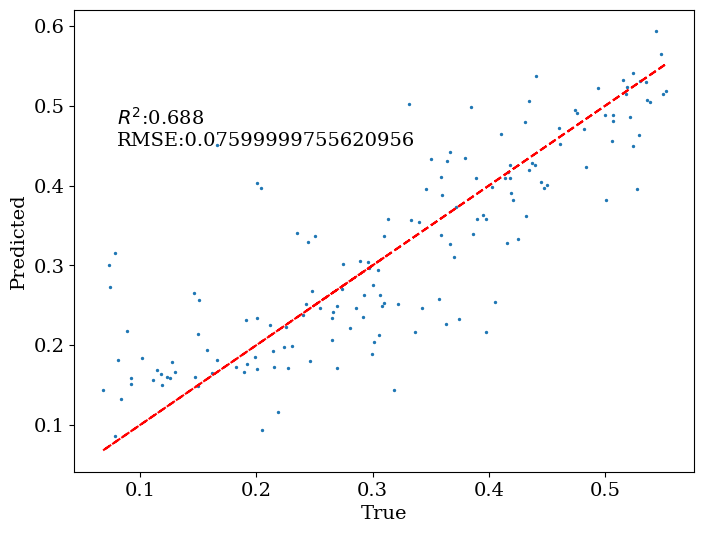

In [27]:
def predict(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_values = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())  # Convert predictions to a list
            true_values.extend(targets.numpy())            # Convert true values to a list
    
    return predictions, true_values

predictions, true_values = predict(model, test_loader)

predictions = np.array(predictions).flatten()
true_values = np.array(true_values).flatten()


plt.figure(figsize=(8,6))
plt.scatter(true_values, predictions, s=2)

RSS = np.square(np.subtract(true_values, predictions)).sum()
TSS = np.square(np.subtract(true_values, np.mean(true_values))).sum()
R_squared = 1 - RSS/TSS
RMSE = np.sqrt(np.square(np.subtract(true_values, predictions)).mean())

plt.text(0.08, 0.45,
        f"$R^2$:{round(R_squared,3)}"
        "\n"
        rf"RMSE:{round(RMSE,3)}"
        # "\n"
        # rf"$\epsilon$:{round(MMRE,3)}"
        # "\n"
        # rf"$\chi^2$:{round(chi_squared,3)}"
        )

plt.xlabel("True")
plt.ylabel("Predicted")
plt.plot(true_values, true_values, color='red', linestyle='--')

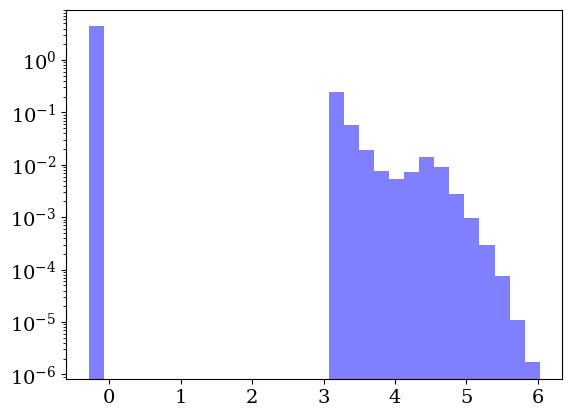

In [15]:
plt.hist(Mbhs, bins = 30, density = True, alpha = 0.5, color = 'blue', label = 'WDM')
plt.yscale('log')


/jet/home/bwangc/.conda/envs/baseEnv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/jet/home/bwangc/.conda/envs/baseEnv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_91136/4010035515.py:7: RuntimeWarning: invalid value encountered in scalar divide
  R_squared = 1 - RSS/TSS
/tmp/ipykernel_91136/4010035515.py:8: RuntimeWarning: Mean of empty slice.
  RMSE = np.sqrt(np.square(np.subtract(trues, predicts)).mean())


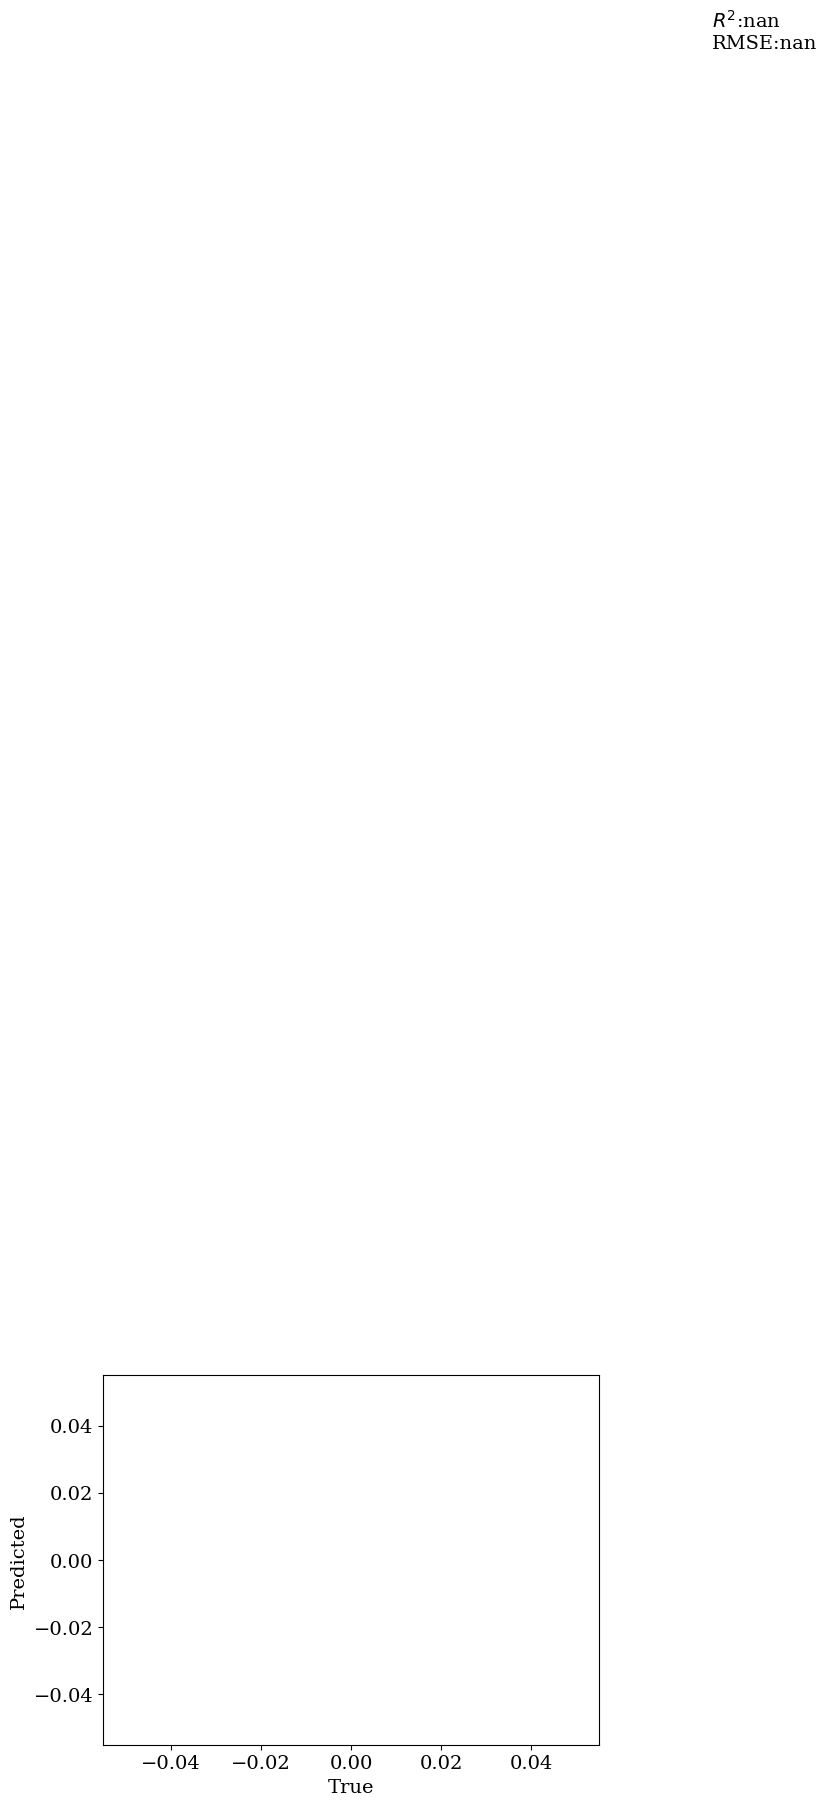

In [94]:
    
    
plt.figure()
plt.scatter(trues, predicts, s = 2)
plt.plot(trues, trues, 'r')

RSS = np.square(np.subtract(trues, predicts)).sum()
TSS = np.square(np.subtract(trues, np.mean(trues))).sum()
R_squared = 1 - RSS/TSS
RMSE = np.sqrt(np.square(np.subtract(trues, predicts)).mean())

plt.text(0.08, 0.45,
        f"$R^2$:{round(R_squared,3)}"
        "\n"
        rf"RMSE:{round(RMSE,3)}"
        # "\n"
        # rf"$\epsilon$:{round(MMRE,3)}"
        # "\n"
        # rf"$\chi^2$:{round(chi_squared,3)}"
        )

plt.xlabel("True")
plt.ylabel("Predicted")
plt.savefig('results/SRModel.pdf')

